In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist

from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

import pdb

/Users/nielswarncke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Visualizing Decision borders on 2D Hyperplanes
The title says it.
First we prepare the experiments
1. Get data and visualize it
2. Define, train and load models
3. Do PCA and the standard PCA visualizations
4. Hyperplane projection and Decision Border visualization

Now we can play around
5. Decision border during training
6. Decision border of a network trained to overfit random labels
7. Adversarial Examples: we can try to explain adversarial examples by showing the decision border in a hyperplane that contains the adversarial noise.
8. Gradient of two class problem as vectorfield in hyperplane

## Data
- Get trained and untrained models
- Load data
- visualize stuff

In [2]:
na = None

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train -= X_train.min()
X_train = X_train / X_train.max()
X_train = 2*X_train - 1

X_test -= X_test.min()
X_test = X_test / X_test.max()
X_test = 2*X_test - 1

Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)

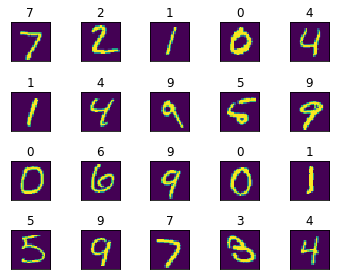

In [3]:

def visualize_digits(X, Y=None):
    X = (X+1)/2
    X = X.reshape([-1, 28, 28])
    rows, cols = int(np.sqrt(len(X))), int(np.ceil(np.sqrt(len(X))))
    fig, axes = plt.subplots(nrows=rows, ncols=cols, squeeze=False,
                            figsize=(cols,rows,))
    for i, x in enumerate(X):
        row = int(i/cols)
        col = i % cols
        ax = axes[row][col]
        if Y is not None:
            y = Y[i]
            ax.set_title(np.argmax(y))
        ax.tick_params(
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False) # labels along the bottom edge are off
        ax.imshow(x)
    plt.tight_layout()
    plt.show()
    
visualize_digits(X_test[:20], Y_test[:20])


# Models and Training

In [4]:
def get_cnn():
    model = Sequential()
    target_shape = X_train.shape[1:] if len(X_train.shape)==4 else list(X_train.shape)[1:] + [1]
    print(target_shape)
    model.add(keras.layers.Reshape(target_shape, input_shape=X_train.shape[1:]))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    
    model.add(Dense(Y_train.shape[1]))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.Adam()

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
              
    return model


              
def get_trained_cnn():
    cnn = get_cnn()
    try:
        cnn.load_weights("cnn.hdf5")
    except Exception as e:
        print("Loading failed: ", type(e), e)
        cnn.fit(X_train, Y_train,
              batch_size=5,
              validation_split=1/6,
              epochs=4)
        cnn.save("cnn.hdf5")
    acc = cnn.evaluate(X_test, Y_test)
    print(acc)
    return cnn


cnn = get_trained_cnn()

    

[28, 28, 1]
10000/10000 [==============================] - 5s 526us/step
[0.04314304168792441, 0.9881]


In [5]:
def get_linear():
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dense(Y_train.shape[1]))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.Adam()

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
              
    return model


def get_trained_linear():
    model = get_linear()
    try:
        model.load_weights("linear.hdf5")
    except Exception as e:
        print("Loading failed: ", type(e), e)
        model.fit(X_train, Y_train,
              batch_size=5,
              validation_split=1/6,
              epochs=4)
        model.save("linear.hdf5")
    acc = model.evaluate(X_test, Y_test)
    print(acc)
    return model

linear = get_trained_linear()

10000/10000 [==============================] - 1s 60us/step
[0.32220052661821247, 0.9152]


# PCA
1. Prepare data (flatten)
2. Do PCA
3. Show eigenvectors and mean
4. Show decreasing eigenvalues

In [6]:
X = X_test.reshape([-1, 784])
print(X_test.shape, X.shape)
Y = Y_test

(10000, 28, 28) (10000, 784)


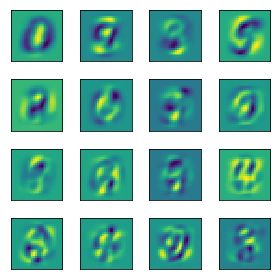

In [7]:
X_mean = np.mean(X, axis=0, keepdims=True)
#X = X - X_mean

#visualize_plt(X_mean)

u, s, v = np.linalg.svd(X-X_mean, full_matrices=False)
visualize_digits(v[:16])

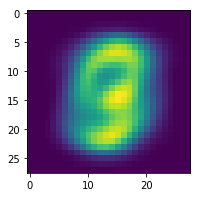

In [8]:

plt.figure(figsize=(3,3,))
plt.imshow(X_mean[0].reshape(28,28))
plt.show()

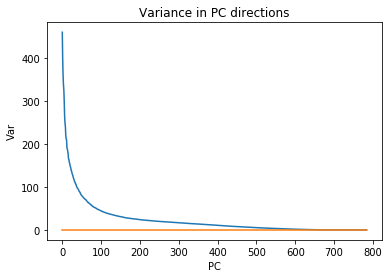

In [9]:
plt.clf()
plt.plot(range(784), s)
plt.plot([0,784], [0,0])
plt.xlabel("PC")
plt.ylabel("Var")
plt.title("Variance in PC directions")
plt.show()


# Hyperplane Projections
A hyperplane can be defined as X_0 + alpha*V_0 + beta*V_1
Let's write a method to project onto that hyperplane, and to project back into the high dimensional space.
If X_0 is the mean of the data, and V_0, V_1 are PCs, this is the projection with the maximum variance ("largest shadow").
We can sample a grid on the hyperplane and visualize the decision border in that hyperplane.

In [10]:
class Plane():
    def __init__(self, X0, V):
        # V: (d, D)
        self.d = V.shape[0]
        assert np.allclose(V.dot(V.T),np.eye(self.d)), "Directions must be orthogonal, change V"
        self.X0, self.V = np.array(X0), np.array(V)
    
    def to_plane(self, X):
        return (X - self.X0).dot(self.V.T)
    
    def from_plane(self, G):
        return G.dot(self.V) + self.X0
    
    def grid_around(self, X, shuffle=False, R=100):
        X_w = self.to_plane(X)

        x_min, x_max = np.min(X_w[:,0]), np.max(X_w[:,0])
        y_min, y_max = np.min(X_w[:,1]), np.max(X_w[:,1])
        scale = np.diag([(x_max-x_min), (y_max-y_min)])
        bias = np.array([x_min, y_min])
        grid = np.indices([R, R]).T.reshape(R*R, -1)/(R-1)
        #for x in Grid_w
        grid = grid.dot(scale) + bias
        X_g = self.from_plane(grid)

        if shuffle:
            perm = np.random.permutation(X_g.shape[0])
            X_g, grid = X_g[perm], grid[perm]
        return X_g
    
    @staticmethod
    def from_pca(PCs):
        return Plane(X_mean, v[PCs])
    
    @staticmethod
    def from_points(X0, X1, X2):
        v0 = X1 - X0
        v0 /= np.linalg.norm(v0)
        
        v1 = X2 - X0
        v1 /= np.linalg.norm(v1)
        v1 -= v1.dot(v0)*v0
        v1 /= np.linalg.norm(v1)
        
        V = np.array([v0,v1])
        print(V.dot(V.T))
        return Plane(X0, V)
        

plane = Plane.from_pca([0,1])


In [11]:
# Test if the grid (on the plane) can losslessy be projected to high and low dimensional space
p = Plane.from_points(X[2], X[3], X[4])

X_g = p.grid_around(X)
grid = p.to_plane(X_g)
xg2 = p.from_plane(grid)
grid2 = p.to_plane(xg2)
xg3 = p.from_plane(grid2)
np.allclose(grid, grid2)
np.allclose(xg2, xg3)
np.allclose(xg2, X_g)

[[1.00000000e+00 4.16333634e-17]
 [4.16333634e-17 1.00000000e+00]]


True

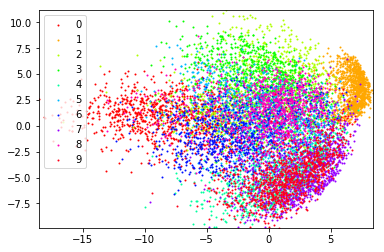

<Figure size 432x288 with 0 Axes>

In [14]:
# Now lets add a method to plot some points on that hyperplane

c = plt.cm.get_cmap("hsv", 10)
colors = [c(i) for i in range(10)]

# pc plot with colors for labels
def plot_classes(X, Y, plane, labels=range(10), s=1, show_legend=True, **kwargs):
    # X_pca: shape (N, d), decorrelated
    X = plane.to_plane(X)
    existing_classes=[]
    for label in labels:
        y = np.argmax(Y, axis=1)
        X_l = X[y==label]
        if X_l.shape[0] == 0:
            continue
        existing_classes.append(label)
        if show_legend:
            plt.scatter(X_l[:,0], X_l[:,1], color=colors[label], label=label, s=s, **kwargs)
        else:
            plt.scatter(X_l[:,0], X_l[:,1], color=colors[label], s=s, **kwargs)
        if show_legend:
            plt.legend()
    plt.xlim(X[:,0].min(), X[:,0].max())
    plt.ylim(X[:,1].min(), X[:,1].max())
    return existing_classes

plot_classes(X, Y, plane)
plt.show()
plt.clf()

[[ 1.00000000e+00 -2.42861287e-17]
 [-2.42861287e-17  1.00000000e+00]]


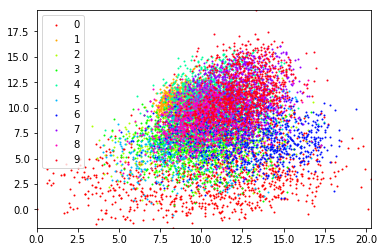

<Figure size 432x288 with 0 Axes>

In [15]:
plot_classes(X, Y, Plane.from_points(X[10], X[3], X[9]))
plt.show()
plt.clf()

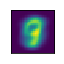

In [16]:
# create a grid, recreate images from assuming the grid is the position in the whitened field
# and plot the classification of these images


test = plane.from_plane(np.array([[1,-1]]))

visualize_digits(test)


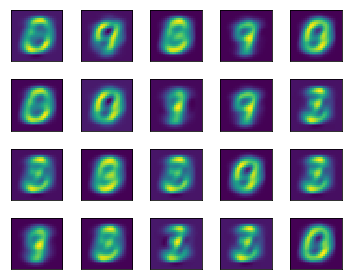

In [17]:
X_g = plane.grid_around(X, shuffle=True)
visualize_digits(X_g[:20]+X_mean)

In [18]:
def show_decision_grid1(plane, model=cnn):
    X_g = plane.grid_around(X)
    Y_g = model.predict(X_g.reshape([-1,28,28]))
    plt.figure(figsize=(6,6))
    labels = plot_classes(X_g, Y_g, plane, labels=range(10), s=1, alpha=0.9, show_legend=False)
    plot_classes(X, Y, plane, labels=labels, s=2)
    plt.show()

def show_decision_grid2(plane, model=cnn):
    X_g = plane.grid_around(X)
    Y_g = model.predict(X_g.reshape([-1,28,28]))
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    labels = plot_classes(X_g, Y_g, plane, labels=range(10), s=1, alpha=0.9)
    plt.subplot(1,2,2)
    plot_classes(X, Y, plane, labels=labels, s=2)
    plt.show()

def show_decision_grid3(plane, model=cnn):
    X_g = plane.grid_around(X)
    Y_g = model.predict(X_g.reshape([-1,28,28]))
    plt.figure(figsize=(6,6))
    labels = plot_classes(X_g, Y_g, plane, labels=range(10), s=1, alpha=0.9, show_legend=False)
    plt.show()
    



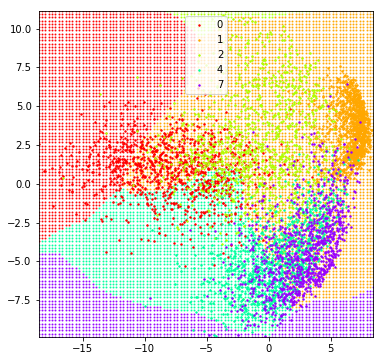

<Figure size 432x288 with 0 Axes>

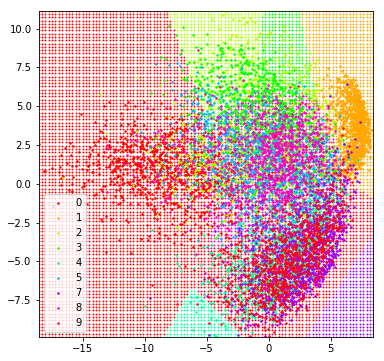

<Figure size 432x288 with 0 Axes>

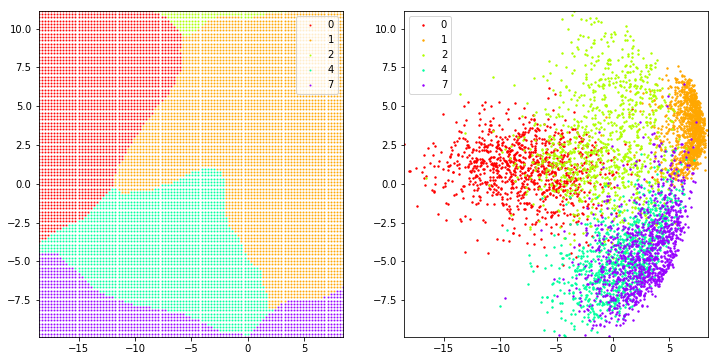

<Figure size 432x288 with 0 Axes>

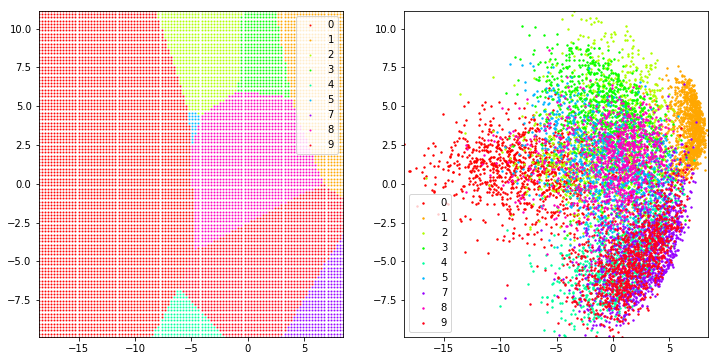

<Figure size 432x288 with 0 Axes>

In [19]:
plane = Plane.from_pca([0,1])
show_decision_grid1(plane)
plt.clf()
show_decision_grid1(plane, linear)
plt.clf()
show_decision_grid2(plane)
plt.clf()
show_decision_grid2(plane, linear)
plt.clf()

In [ ]:
np.allclose(plane.X0, X_mean)

In [ ]:
np.all(np.isfinite(X))

In [ ]:
show_decision_grid2(Plane.from_points(X[3], X[1], X[2]), cnn)
show_decision_grid2(Plane.from_pca([0,1]), cnn)

# Move along another axis
We can gradually change the offset and move the plane through the space. Lets create something to make a gif from that

In [20]:

class AnimatedScatter(object):
    """An animated scatter plot using matplotlib.animations.FuncAnimation."""
    def __init__(self, plane, X, model, change, iterations=10, labels=range(10)):
        self.labels = labels
        self.generate_data(plane, X, model, change, iterations)

        # Setup the figure and axes...
        plt.clf()
        self.fig, self.ax = plt.subplots(figsize=(6,6))
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=5, frames=range(iterations),
                                           init_func=self.setup_plot, blit=True)

    def setup_plot(self):
        """Initial drawing of the scatter plot."""
        x, y = self.X[0], self.Y[0]
        xmin, xmax = self.X[:,:,0].min(), self.X[:,:,0].max()
        ymin, ymax = self.X[:,:,1].min(), self.X[:,:,1].max()
        
        self.scat = self.ax.scatter(x[:,0], x[:,1], c=y, s=2, animated=True)
        self.ax.axis([xmin, xmax, ymin, ymax]) # TODO borders

        # For FuncAnimation's sake, we need to return the artist we'll be using
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,
    
    def generate_data(self, plane, X, model, change, iterations):
        # change: method that changes the model or the plane or whatever
        frames_x, frames_y = [], []
        for i in range(iterations):
            x_D = plane.grid_around(X)
            x = plane.to_plane(x_D)
            y = np.argmax(model.predict(x_D.reshape((-1, 28, 28,))), axis=1)
            frames_x.append(x)
            frames_y.append(y)
            
            change(plane, X, model)
            
        self.X = np.array(frames_x)
        self.Y = np.array(frames_y)
            

    def update(self, i):
        if i == 0:
            self.scat.set_visible(True)
        # Set x and y data
        self.scat.set_offsets(self.X[i])
        # Set colors..
        self.scat.set_array(self.Y[i])

        # We need to return the updated artist for FuncAnimation to draw..
        # Note that it expects a sequence of artists, thus the trailing comma.
        return self.scat,

    def show(self):
        return HTML(self.ani.to_jshtml())


In [ ]:
class MovingPlane():
    def __init__(self, plane, l, steps=10):
        # l : move direction
        self.plane = plane
        self.plane.X0 += X.dot(l).min()*l
        r = X.dot(l).max() - X.dot(l).min()
        self.l = l*r/steps
        
    def move(self, *args):
        self.plane.X0 += self.l
        
p = Plane.from_pca([0,1])
mv = MovingPlane(p, v[3], 1)
    
a = AnimatedScatter(p, X, cnn, mv.move, 3)
a.show()

# Visualize Training
We now want to visualize, how the decision borders in the hyperplane of the first two PCs changes during training.
1. Define new networks
2. Write method to train them on batches and visualize the decision border after each time

In [ ]:

show_decision_grid1(plane)
plt.clf()

# Visualize Overfitting
Lets see, if we can explain overfitting using this method. We shuffle the labels, and use as train and validation set a small and identical subset of our data.
1. Shuffle labels
2. Get new network
3. Do experiment from above

# Adversarial Examples
We know, that whereever we are, we are close to the border of any other class - we know it because of adversarial examples. In the PC dimensions, the decision volumes look pretty compact and only a small portion of samples is close to the borders. Let´s choose a random real digit, generate the adversarial examples and show the decision borders in a hyperplane that contains the change (x_originak-x_adversarial).

We can try to answer this question:
Are we always close, because there are hyperplanes in which the decision borders are not compact (many points are close too a border)
or
Is every point always close to some border, because in every hyperplane a small fraction of points is close to a border, but as we have so many of them, the fractions add up to the whole space?

# Visualize Gradient during training
For a two class problem, 